## Rectangular waveguide - Discussion

In [1]:
import os
import sys
import fenics as fen
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg

In [2]:
sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath('__file__')))))
from rectangular_waveguide import RectangularWaveguide
import src.helpers as helpers

### Dimensions and properties

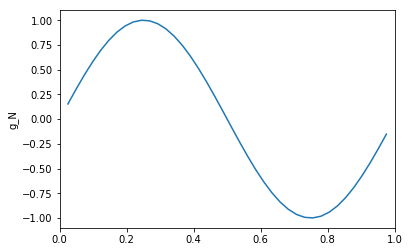

In [3]:
Lx, Ly = 5.0, 1.0
Nx, Ny = 201, 41
m = 2
g_N = fen.Expression('sin(x[1]*m*pi/Ly)', degree=2, Ly=Ly, m=m)
WG = RectangularWaveguide(Lx=Lx, Ly=Ly, Nx=Nx, Ny=Ny, g_N=g_N)
WG.plot_g_N()

### Solution of problem

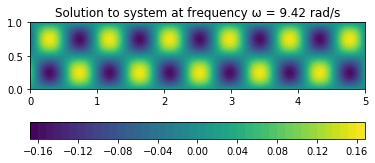

In [6]:
WG.setup()
WG.solve(9.42)
WG.plot_solution()

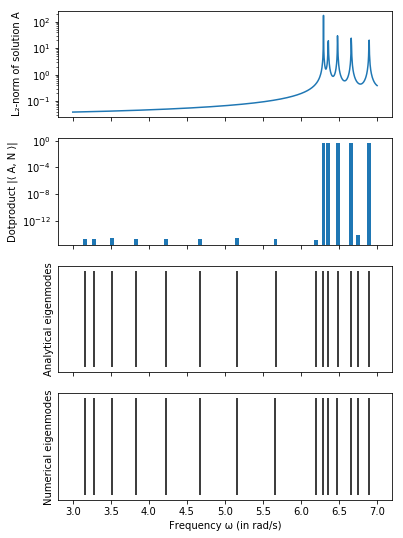

In [35]:
fig, ax = plt.subplots(4, 1, figsize=(6, 9), sharex=True)
omegas = np.linspace(3, 7, 1000)
helpers.plot_L2_norms(ax[0], WG, omegas)
helpers.plot_eigvecs_dot_N(ax[1], WG, omegas[0], omegas[-1], width=0.05)
helpers.plot_numerical_eigenfrequencies(ax[2], WG, omegas[0], omegas[-1])
helpers.plot_analytical_eigenfrequencies(ax[3], WG, omegas[0], omegas[-1])
ax[0].set_ylabel('L\u2082-norm of solution A')
ax[1].set_ylabel('Dotproduct |\u27E8 A, N \u27E9|')
ax[2].set_ylabel('Analytical eigenmodes')
ax[2].set_yticks([])
ax[3].set_ylabel('Numerical eigenmodes')
ax[3].set_yticks([])
ax[3].set_xlabel('Frequency \u03C9 (in rad/s)')
plt.show()

### Timing

In [4]:
omega = WG.get_analytical_eigenfrequencies(0, 10)[0]

#### FEniCS solver

In [7]:
LHS = WG.get_K(tosparse=False) - omega**2 * WG.get_M(tosparse=False)
RHS = WG.get_L(get_local=False) + WG.get_N(get_local=False)
A_sol = fen.Function(WG.get_V())
%timeit fen.solve(LHS, A_sol.vector(), RHS)

63.6 ms ± 4.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### SciPy sparse Hermitian eigenvalue solver

In [8]:
valid_indices = WG.get_valid_indices()
K = WG.get_K()[valid_indices, :][:, valid_indices]
M = WG.get_M()[valid_indices, :][:, valid_indices]
%timeit scipy.sparse.linalg.eigsh(K, k=1, M=M, sigma=omega**2)

234 ms ± 14.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
